In [1]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/dataset91/data.py", dst = "../working/data.py")
copyfile(src = "../input/dataset91/utils.py", dst = "../working/utils.py")
copyfile(src = "../input/dataset91/training.py", dst = "../working/training.py")
copyfile(src = "../input/dataset91/layers.py", dst = "../working/layers.py")
#copyfile(src = "../input/notes1/weights2.npy", dst = "../working/weights2.npy")
# import all our functions
#from data import load_data

'../working/layers.py'

In [2]:
# Estimate the GPS clusters
print("Estimating clusters...")
#clusters = get_clusters(data.train_labels)
n_epochs=100
batch_size=200
save_prefix='mymodel'
config=3


Estimating clusters...


In [3]:
#import pickle
!pip install pickle5
import csv
import calendar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator, FormatStrFormatter
from scipy.interpolate import splrep
from IPython.core.display import display_html
from keras.models import load_model
from utils import np_haversine, density_map, get_clusters, plot_embeddings
from data import load_data
#from training import start_new_session, process_features, create_model

# Display plots inline
%matplotlib inline

# Fix random seed for reproducibility
np.random.seed(42)

     |████████████████████████████████| 256 kB 286 kB/s            


In [4]:
def start_new_session():
    """
    Starts a new Tensorflow session.
    """
    
    # Make sure the session only uses the GPU memory that it actually needs
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    
    session = tf.compat.v1.Session(config=config, graph=tf.compat.v1.get_default_graph())
    tf.compat.v1.keras.backend.set_session(session)

In [5]:
clusters_cache = '/kaggle/input/fp2021/clusters.npy'
clusters=np.load(clusters_cache, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [6]:
file='/kaggle/input/fp2021/train0.npy'
train0=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
file='/kaggle/input/fp2021/train1.npy'
train1=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
file='/kaggle/input/fp2021/train2.npy'
train2=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
file='/kaggle/input/fp2021/train3.npy'
train3=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
file='/kaggle/input/fp2021/train4.npy'
train4=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
file='/kaggle/input/fp2021/train5.npy'
train5=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
file='/kaggle/input/fp2021/train6.npy'
train6=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
train=[train0,train1,train2,train3,train4,train5,train6]

In [7]:
file='/kaggle/input/fp2021/validation0.npy'
validation0=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
file='/kaggle/input/fp2021/validation1.npy'
validation1=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
file='/kaggle/input/fp2021/validation2.npy'
validation2=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
file='/kaggle/input/fp2021/validation3.npy'
validation3=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
file='/kaggle/input/fp2021/validation4.npy'
validation4=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
file='/kaggle/input/fp2021/validation5.npy'
validation5=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
file='/kaggle/input/fp2021/validation6.npy'
validation6=np.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
validation=[validation0,validation1,validation2,validation3,validation4,validation5,validation6]

In [8]:
train=train[6]
validation=validation[6]

In [9]:
!pip3 install pickle5
import pickle5 as pickle
metadata_cache = '/kaggle/input/fp2021/metadata.pickle'
with open(metadata_cache, 'rb') as handle:
    metadata = pickle.load(handle)
tl_cache = '/kaggle/input/fp2021/train-labels.npy'
vl_cache = '/kaggle/input/fp2021/validation-labels.npy'
train_labels=np.load(tl_cache, mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
validation_labels=np.load(vl_cache, mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')

In [10]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import scale
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Reshape, Activation, Dropout
from keras.layers import *
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from utils import tf_haversine
from data import load_data
from utils import get_clusters
from keras.models import Model

from tensorflow.compat.v1.keras.layers import LSTM   # CuDNNLSTM
from tensorflow.compat.v1.keras.layers import GRU
import sys
sys.path.append('..')  # add parent directory to Python path for layers.py access
from layers import Attention, SelfAttention

def create_model(metadata,clusters,config):
    """
    Creates all the layers for our neural network model.
    """
      
    # Arbitrary dimension for all embeddings
    embedding_dim = 10

    
    
    # GPS coordinates (5 first lat/long and 5 latest lat/long, therefore 20 values)
    coords = Sequential()
    coords.add(Dense(1, input_dim=20,input_shape=(20,1)))

    # Merge all the inputs into a single input layer
    mergedOut = coords.output
    
    #encoder_output, hidden_state, cell_state = LSTM(50, activation='tanh',input_shape=(None,None, 1),
    #                                                return_sequences=True,return_state=True)(mergedOut)
    #attention_input = [encoder_output, hidden_state]
    gru_layer=tf.keras.layers.GRU(200, return_sequences=True,return_state=True)
    if config != 0:
        #encoder_output, hidden_state, cell_state = LSTM(units=200,
        #                                                 return_sequences=True
        #                                                ,return_state=True#,input_shape=(50,1)
        #                                               )(mergedOut)
        encoder_output, hidden_state, cell_state = Bidirectional(gru_layer,
                                                                      merge_mode="sum")(mergedOut)
        attention_input = [encoder_output, hidden_state]
    else:
        encoder_output = LSTM(units=64)(mergedOut)

    # Optional Attention Mechanisms
    if config == 1:
        encoder_output, attention_weights = SelfAttention(size=64,
                                                      num_hops=10,
                                                      use_penalization=False)(encoder_output)
    elif config == 2:
        encoder_output, attention_weights = Attention(context='many-to-one',
                                                  alignment_type='global')(attention_input)
        encoder_output = Flatten()(encoder_output)
    elif config == 3:
        encoder_output, attention_weights = Attention(context='many-to-one',
                                                  alignment_type='local-m',
                                                  window_width=10,
                                                  score_function='general')(attention_input)
        encoder_output = Flatten()(encoder_output)
        
    
    #encoder_output=Dense(1)(encoder_output)
    # Determine cluster probabilities using softmax
    mergedOut=Dense(len(clusters))(encoder_output)
    mergedOut=Activation('softmax')(mergedOut)

    # Final activation layer: calculate the destination as the weighted mean of cluster coordinates
    cast_clusters = K.cast_to_floatx(clusters)
    def destination(probabilities):
        return tf.matmul(probabilities, cast_clusters)
    mergedOut=Activation(destination)(mergedOut)

    newModel = Model([coords.input],mergedOut)
    #use lists if you want more than one input or output  
    
    # Compile the model
    optimizer = SGD(lr=0.1, momentum=0.9, clipvalue=1.)  # Use `clipvalue` to prevent exploding gradients

    newModel.compile(loss=tf_haversine, optimizer=optimizer)
    
    return newModel

In [11]:
model=create_model(metadata,clusters,config)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 20, 1)        2           dense_input[0][0]                
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 20, 200), (N 243600      dense[0][0]                      
__________________________________________________________________________________________________
attention (Attention)           ((None, 10, 200), (N 40000       bidirectional[0][0]              
                                                                 bidirectional[0][1]          

In [13]:
e=[]
f=[]
g=[]
for i in range(96):
    f.append(0)
    e.append(0)
    g.append(0)

In [14]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        global training_finished
        training_finished = True
    def on_epoch_end(self, epoch, logs=None):
        z=len(e)
        if z>len(g):
            a=model.history.history['val_loss'][z-len(g)-1]
            b=model.history.history['loss'][z-len(g)-1]
            c=float(a)-float(b)
            if c<0:
                print("Sebelumnya Underfitting")
            else:
                print("Sebelumnya Overfitting")
        e.append(0)
            

In [15]:
class CustCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        global training_finished
        training_finished = True
    def on_epoch_end(self, epoch, logs=None):
        z=len(f)
        file_path="../working/Newweights"+str(z)
        weight=model.get_weights()
        np.save(file_path, weight)
        f.append(0)

In [16]:
file='../input/latbigru82gpslocmnew/Newweights'+str(len(g)-1)+'.npy'
#file='./Newweights'+str(len(g)-1)+'.npy'
b=np.load(file, mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
model.set_weights(b)

In [17]:
file='../input/fp2021/train-labels.npy'
train_labels=np.load(file, mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
file='../input/fp2021/validation-labels.npy'
validation_labels=np.load(file, mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')

In [18]:
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.callbacks import EarlyStopping
 
callbacks = []
if save_prefix is not None:
        # Save the model's intermediary weights to disk after each epoch
    file_path="cache/%s-{epoch:03d}-{val_loss:.4f}.hdf5" % save_prefix
    checkpoint = ModelCheckpoint(file_path,monitor='val_loss',mode='auto',save_weights_only=True,verbose=0)
    #checkpoint = weight_save(model.get_weights(),b)
    callbacks.append(checkpoint)
    #callbacks.append(ModelCheckpoint(file_path, monitor='val_loss', mode='min', save_weights_only=True, verbose=1))
    #callbacks.append(ModelCheckpoint(file_path, monitor='val_loss', verbose=0, save_best_only=False, mode='auto'))
    #model.fit(X_train,y_train,batch_size=batch_size,nb_epoch=nb_epoch,callbacks=[weight_save_callback])
#g.append(0)
#epoch>1

#first epoch
#saver = weight_save(model.get_weights(),b)   
#es = EarlyStopping(monitor='val_loss', patience=0, verbose=1)
arc='LATBiGRUnew91-b200-'+str(len(g))+'.log'
csv_logger = CSVLogger(arc, separator=',', append=False)
print("Creating model...")
start_new_session()
print("Train model...")
history=model.fit(train, train_labels,
        initial_epoch=len(g),epochs=100, batch_size=batch_size,
        validation_data=(validation, validation_labels)
        ,callbacks=[csv_logger,CustCallback(),MyCallback()])
#if save_prefix is not None:
        # Save the training history to disk
#        file_path = 'cache/%s-history.pickle' % save_prefix
#        with open(file_path, 'wb') as handle:
#            pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Creating model...


2021-12-29 07:54:43.839838: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Train model...


2021-12-29 07:54:44.425006: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 97/100


2021-12-29 07:54:47.852377: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2200 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6578/6578 [==============================] - ETA: 0s - loss: 1.4435

2021-12-29 08:25:26.309849: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2200 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6578/6578 [==============================] - 2000s 303ms/step - loss: 1.4435 - val_loss: 1.4914


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 98/100
6578/6578 [==============================] - 1971s 300ms/step - loss: 1.4676 - val_loss: 1.4463
Sebelumnya Overfitting
Epoch 99/100
6578/6578 [==============================] - 1976s 300ms/step - loss: 1.4325 - val_loss: 1.4370
Sebelumnya Underfitting
Epoch 100/100
6578/6578 [==============================] - 1999s 304ms/step - loss: 1.4297 - val_loss: 1.4377
Sebelumnya Overfitting


In [19]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator, FormatStrFormatter
def Visual(x,str):
    y=len(x)/3
    a=[]
    for i in range(len(x)):
        if y>0:
            a.append(x[3*(i+1)-2])
            y=y-1

    y=len(x)/3
    z=[]

    for i in range(len(x)):
        if y>0:
            z.append(x[3*(i+1)-1])
            y=y-1

    train_loss = a
    vals_loss = z


    n_epochs = len(vals_loss)
    plt.figure(figsize=(16,6))
    plt.plot(train_loss)
    plt.plot(vals_loss)
    plt.title('Grafik loss value dari '+str,fontsize=20)
    plt.ylabel('loss',fontsize=14)
    plt.xlabel('epoch',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    #plt.axes().xaxis.set_major_locator(MultipleLocator(10))
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

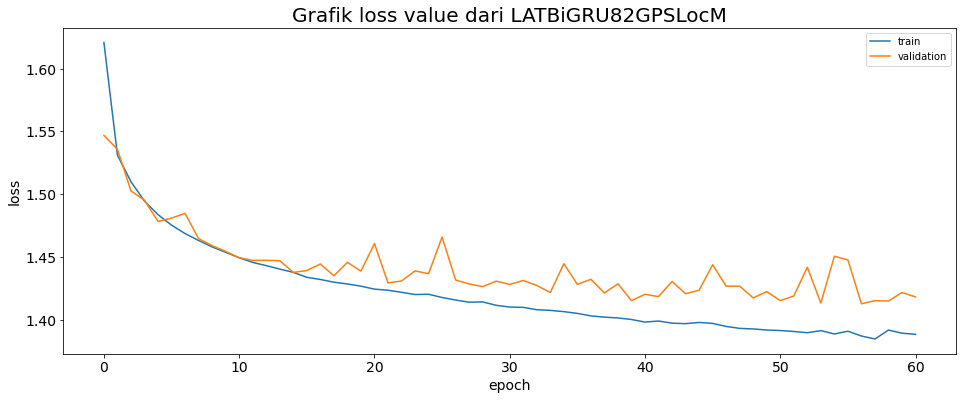

In [20]:
LATBiGRU82GPSLocM=[0,1.620782494544983,1.5467314720153809,
1,1.5310229063034058,1.5357006788253784,
2,1.5098614692687988,1.5025385618209839,
3,1.4944175481796265,1.4951272010803223,
4,1.4836180210113525,1.4782040119171143,
5,1.475231647491455,1.4808485507965088,
6,1.4685497283935547,1.4846439361572266,
7,1.4630366563796997,1.4645203351974487,
8,1.457905650138855,1.4588757753372192,
9,1.453626036643982,1.4543240070343018,
10,1.4492913484573364,1.4493093490600586,
11,1.445565104484558,1.4471769332885742,
12,1.443002462387085,1.4472408294677734,
13,1.4402581453323364,1.446915864944458,
14,1.4376410245895386,1.4375627040863037,
15,1.433687448501587,1.4391182661056519,                 
16,1.4319692850112915,1.4443061351776123,
17,1.4297970533370972,1.4348958730697632,
18,1.4283829927444458,1.4456217288970947,
19,1.426635503768921,1.4386032819747925,
20,1.4242695569992065,1.460589051246643,
21,1.423406720161438,1.4292230606079102,
22,1.4217464923858643,1.4307681322097778,
23,1.4199912548065186,1.4388295412063599, 
24,1.4201868772506714,1.4365483522415161,
25,1.4176052808761597,1.4658223390579224,
26,1.415587067604065,1.4315448999404907,
27,1.4138723611831665,1.4283888339996338,
28,1.4140864610671997,1.42626953125,
29,1.4113733768463135,1.4306086301803589,
30,1.4099901914596558,1.4280167818069458,
31,1.4097520112991333,1.4311758279800415,
32,1.4078885316848755,1.4271973371505737,
33,1.407347559928894,1.4215623140335083,
34,1.406342625617981,1.4445288181304932,
35,1.4049564599990845,1.4280767440795898,
36,1.4029335975646973,1.432108759880066,
37,1.4019774198532104,1.4212027788162231,
38,1.4012939929962158,1.4285355806350708,
39,1.4000957012176514,1.4150772094726562,
40,1.398024082183838,1.4201633930206299,
41,1.3988615274429321,1.4182828664779663,
42,1.3971749544143677,1.4303488731384277,
43,1.396782636642456,1.4206347465515137,
44,1.3977303504943848,1.423352837562561,
45,1.3969743251800537,1.4437217712402344,
46,1.3945657014846802,1.4266067743301392,     
47,1.3930027484893799,1.4266595840454102,
48,1.3925656080245972,1.4172794818878174,
49,1.3917012214660645,1.4222939014434814,
50,1.3912938833236694,1.415103554725647,  
51,1.3905314207077026,1.418803334236145,
52,1.3895493745803833,1.4417307376861572,
53,1.391232967376709,1.4132122993469238,
54,1.3885414600372314,1.4504647254943848,
55,1.3907458782196045,1.447532296180725,
56,1.3869048357009888,1.412626028060913,
57,1.3845665454864502,1.4150792360305786,
58,1.3916577100753784,1.4148242473602295,
59,1.3891868591308594,1.4215879440307617,
60,1.388257384300232,1.4180715084075928,                 
]
Visual(LATBiGRU82GPSLocM,'LATBiGRU82GPSLocM')

In [21]:
t=0
while(t<1):
    t=t

KeyboardInterrupt: 